In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
import h5py
import pandas as pd
import seaborn as sns
import ringdown as rd
from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise
from pycbc.inference import io, models
from pycbc.workflow import WorkflowConfigParser
from pycbc import detector
import lal
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

/work/yifan.wang/virtualenv/ringdown/lib/python3.7/site-packages/pyRing/utils.py:16: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


# Ringdown results

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

In [4]:
T = 0.2
srate = 4096
fit = rd.Fit(model='mchi_aligned')
fit.set_tone_sequence(2)

for s in raw_strain.values():
    fit.add_data(s)

fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
# compute autocovariance functions
fit.compute_acfs()

# Using Stan's optimization function

In [5]:
fit.update_prior(A_scale=5e-20, M_min=35, M_max=140, cosi_max=-0.99, flat_A=1)
stan_data = fit.model_input
stan_data['only_prior']=0
par = fit._model.optimizing(data=stan_data)

Initial log joint probability = -382739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       79210.5      0.152997       263.024           1           1       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       79264.1     0.0075346       3.84494           1           1       45   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       79264.1    0.00031257       1.97949           1           1       53   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [6]:
par

OrderedDict([('log_drift_unit', array([0.14647875, 0.7470187 ])),
             ('M', array(53.42761387)),
             ('chi', array(0.00858798)),
             ('cosi', array(-0.99574437)),
             ('iota_unit', array([0.72528815, 0.68844542])),
             ('Ax_unit', array([ 0.04714082, -0.04320251])),
             ('Ay_unit', array([ 0.02204964, -0.04225512])),
             ('dts', array(-3.47557146e-07)),
             ('df', array([0.18757647, 0.32666209])),
             ('dtau', array([0.29633645, 0.05791222])),
             ('drift', array([1., 1.])),
             ('gamma', array([ 338.01891973, 1040.85541666])),
             ('f', array([226.77891402, 210.61020002])),
             ('h_det_mode',
              array([[[ 1.61198264e-021,  2.48810385e-021,  2.94084763e-021,
                       ...,  2.18069518e-050,  1.89786999e-050,
                        1.43681087e-050],
                      [-4.51025113e-022, -1.44367623e-021, -1.85226129e-021,
                      

In [7]:
f = par['f'] #frequency
gamma = par['gamma'] #gamma is just 1/tau
A = par['A'] #amplitude
phi = par['phi'] #phase
tau = par['tau'] #tau
cosi = par['cosi'] 
M = float(par['M'])
chi = float(par['chi'])
fpfc = stan_data['FpFc']
t0 = stan_data['t0']
times = stan_data['times']

# Visulization

In [8]:
%matplotlib inline

Text(0, 0.5, 'Strain')

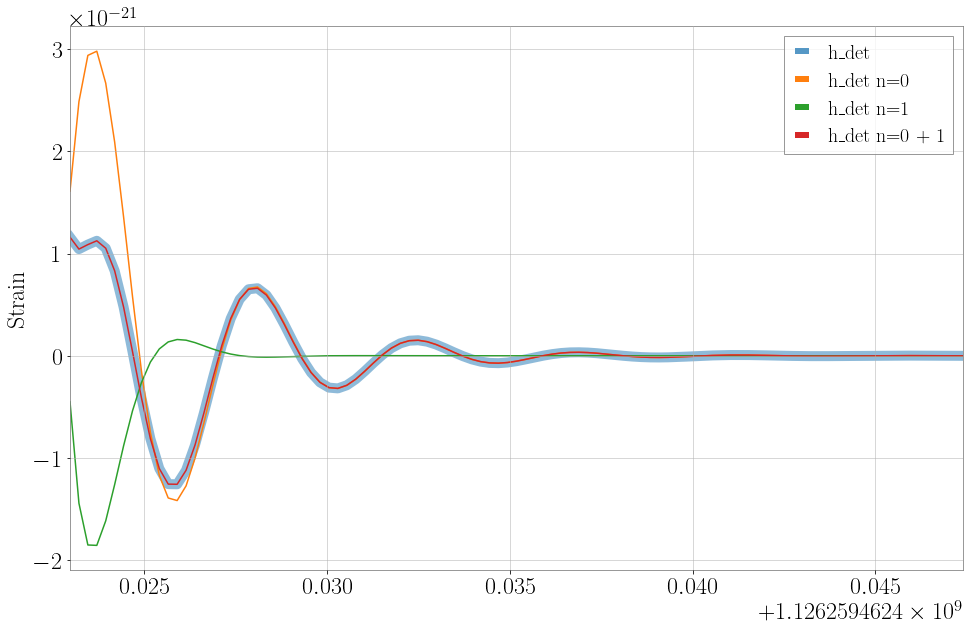

In [9]:
plt.figure(figsize=[16,10])

t_h1 = fit.analysis_data['H1'].index
s_h1 = par['h_det'][0]
s_h1_220 = par['h_det_mode'][0][0]
s_h1_221 = par['h_det_mode'][0][1]

plt.plot(t_h1,s_h1,lw=10,alpha=0.5,label='h_det')
plt.plot(t_h1,s_h1_220,label='h_det n=0')
plt.plot(t_h1,s_h1_221,label='h_det n=1')
plt.plot(t_h1,s_h1_220+s_h1_221,label='h_det n=0 + 1')
plt.legend(loc='best')
plt.xlim(t_h1[0], t_h1[0] + 100 * (t_h1[1]-t_h1[0]))
plt.ylabel('Strain')

# PyRing waveform

In [1]:
input_par = {'data-H1': '', 
             'data-L1': '', 
             'data-V1': '', 
             'ignore-data-filename': 0, 
             'download-data': 1, 
             'datalen-download': 4096.0, 
             'gw-data-find': 0, 
             'gw-data-type-H1': '', 
             'gw-data-type-L1': '', 
             'gw-data-type-V1': '', 
             'tag': 'CLN', 
             'channel-H1': 'GWOSC', 
             'channel-L1': 'GWOSC', 
             'channel-V1': 'GWOSC', 
             'config-file': 'config_gw150914_production.ini', 
             'run-type': 'full', 
             'output': 'GW150914_PROD1_Kerr_221_0M', 
             'run-tag': 'PROD1', 
             'screen-output': 0, 
             'pesummary': 1, 
             'trigtime': 1126259462.423, 
             'detectors': ['H1', 'L1'], 
             'ref-det': 'H1', 
             'sky-frame': 'equatorial', 
             'acf-H1': '', 
             'acf-L1': '', 
             'acf-V1': '', 
             'psd-H1': '', 
             'psd-L1': '', 
             'psd-V1': '', 
             'signal-chunksize': 4.0, 
             'noise-chunksize': 4.0, 
             'window-onsource': 0, 
             'window': 1, 
             'alpha-window': 0.1, 
             'sampling-rate': 4096, 
             'f-min-bp': 20.0, 
             'f-max-bp': 2038.0, 
             'bandpassing': 1, 
             'fft-acf': 1, 
             'acf-simple-norm': 1, 
             'no-lognorm': 0, 
             'truncate': 1, 
             'analysis-duration': 0.2, 
             'analysis-duration-n': int(0.2*4096),
             'zero-noise': 0, 
             'gaussian-noise': '', 
             'gaussian-noise-seed': -1, 
             'gaussian-noise-white-sigma': 1e-21, 
             'chisquare-computation': 0, 
             'non-stationarity-check': 0, 
             'onsource-ACF': 0, 
             'noise-averaging-method': 'mean', 
             'Dirac-comb': 0, 
             'Zeroing-data': 0, 
             'maxent-psd': '', 
             'PSD-investigation': 0, 
             'injection-parameters': None, 
             'injection-approximant': '', 
             'inject-n-ds-modes': {'t': 1}, 
             'inject-area-quantization': 0, 
             'inject-charge': 0, 
             'injection-scaling': 1.0, 
             'injection-T': 64.0, 
             'template': 'Kerr', 
             'single-mode': None, 
             'n-ds-modes': {'t': 1}, 
             'ds-ordering': 'freq', 
             'kerr-modes': [(2, 2, 2, 0), (2, 2, 2, 1)], 
             'reference-amplitude': 1e-21, 
             'spheroidal': 0, 
             'qnm-fit': 1, 
             'coherent-n': 0, 
             'amp-non-prec-sym': 1, 
             'max-Kerr-amp-ratio': 0.0, 
             'TGR-overtones-ordering': 'Unordered', 
             'domega-tgr-modes': None, 
             'dtau-tgr-modes': None, 
             'area-quantization': 0, 
             'tau-AQ': 0, 
             'prior-reweight': 0, 
             'ParSpec': 0, 
             'ParSpec_Dmax_TGR': 2, 
             'ParSpec_Dmax_charge': 0, 
             'EsGB': 0, 
             'charge': 0, 
             'gr-time-prior': 1, 
             'dist-flat-prior': 0, 
             'ds-amp-flat-prior': 0, 
             'mf-time-prior': 67.92493161247017, 
             'nonref-det': 'L1'}
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**input_par)

NameError: name 'pyRing' is not defined

In [11]:
model.fixed_params

{'ra': 1.95, 'dec': -1.27, 'psi': 0.82, 't': 0.0, 'cosiota': -1.0, 'phi': 0.0}

# Mapping the ringdown waveform parameters to pyring

In [12]:
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M,
 'af': chi,
 'A2220': A[0]/1e-21*prefactor,
 'A2221': A[1]/1e-21*prefactor,
 'phi2220': -phi[0],
 'phi2221': -phi[1]}
model.log_likelihood(pyring_par)

77814.69186842287

In [13]:
wf_model = model.get_waveform(pyring_par)

In [14]:
ra = model.fixed_params['ra']
dec = model.fixed_params['dec']
psi = model.fixed_params['psi']
t_start = model.fixed_params['t']
duration_n = model.duration_n

likelihood.loglikelihood(model,pyring_par,wf_model,
                        ra,dec,psi,t_start,
                        model.time_delay,
                        model.ref_det,
                        1,
                        int(4096*0.2),
                        0,
                        0,
                        0)

77814.69186842287

# Inside the loglikelihood function, the wf_model.waveform is called

In [15]:
pyring_wf = {}
time_array = {}
dt = {}
pyring_data = {}
#extract the pyring data and GW template
for det in ['H1','L1']:
    dt[det]   = model.time_delay['H1_'+det]
    time_array_raw = model.detectors[det].time - (model.tevent+dt[det])
    time_array[det]     = time_array_raw[time_array_raw >= t_start][:duration_n] #duration_n means 0.2s data
    pyring_data[det] = model.detectors[det].time_series[time_array_raw >= t_start][:duration_n]
    #hp, hc
    hs,hvx,hvy,hp,hc = wf_model.waveform(time_array[det])
    tref = lal.LIGOTimeGPS(t_start+model.tevent+dt[det])
    #project hp and hc to LIGO detectors
    pyring_wf[det] = likelihood.project(
        hs, hvx, hvy, hp, hc, model.detectors[det].lal_detector, ra, dec, psi, tref)

In [16]:
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

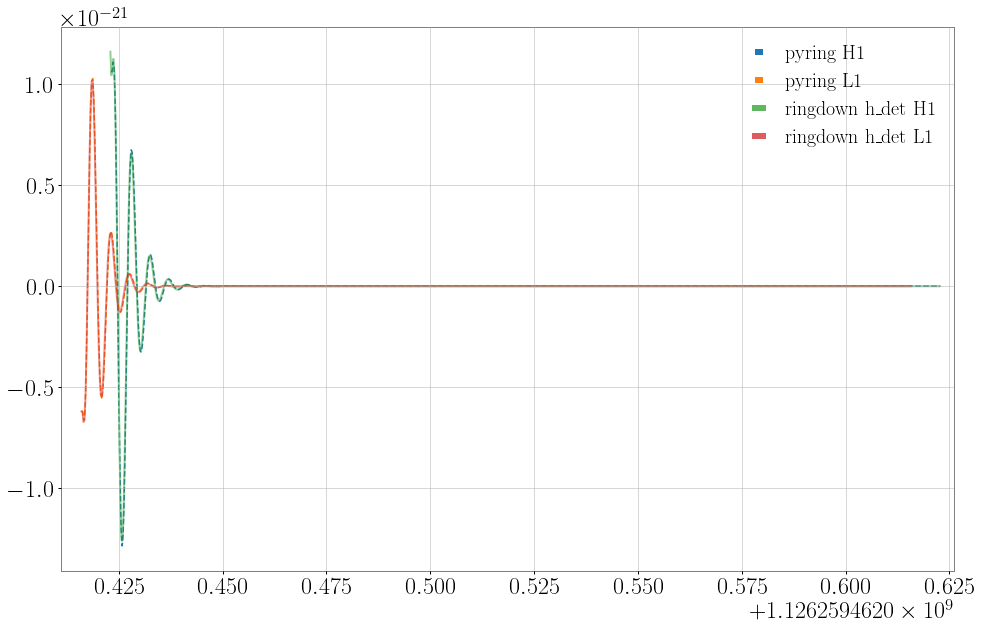

In [17]:
plt.figure(figsize=[16,10])

plt.plot(model.tevent+time_array['H1']+dt['H1'],pyring_wf['H1'],ls='--',label='pyring H1')
plt.plot(model.tevent+time_array['L1']+dt['L1'],pyring_wf['L1'],ls='--',label='pyring L1')
plt.plot(fit.analysis_data['H1'].index,par['h_det'][0],alpha=0.5,lw=2,label='ringdown h_det H1')
plt.plot(fit.analysis_data['L1'].index,par['h_det'][1],alpha=0.5,lw=2,label='ringdown h_det L1')

plt.xlim(fit.analysis_data['L1'].index[0]-0.005,fit.analysis_data['L1'].index[0]+0.21)
plt.legend(loc='best')

# Reverse the phase and time shift the L1 data

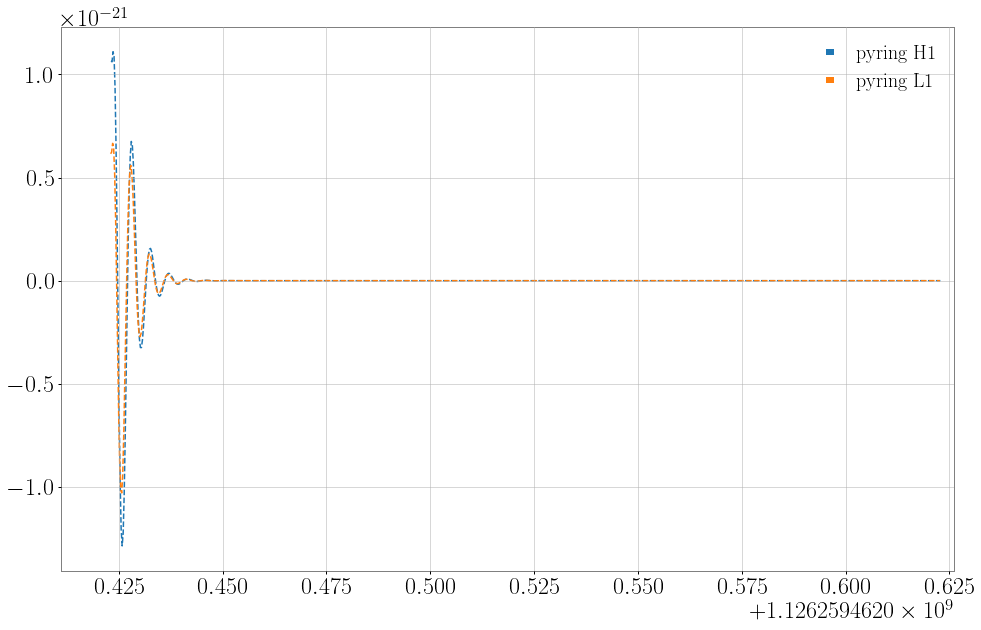

In [18]:
plt.figure(figsize=[16,10])

plt.plot(model.tevent+time_array['H1']+dt['H1'],pyring_wf['H1'],ls='--',label='pyring H1')
plt.plot(model.tevent+time_array['L1'],-pyring_wf['L1'],ls='--',label='pyring L1')

plt.xlim(fit.analysis_data['L1'].index[0]-0.005,fit.analysis_data['L1'].index[0]+0.21)
plt.legend(loc='best')

# Check the Strain Data

In [19]:
len(pyring_data['H1'])

819

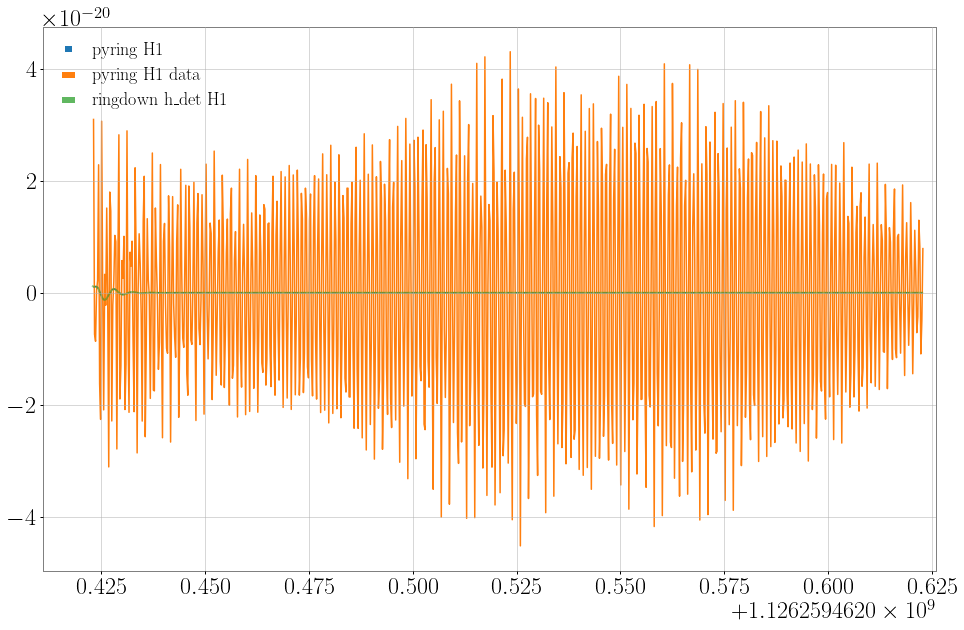

In [20]:
plt.figure(figsize=[16,10])

plt.plot(model.tevent+time_array['H1']+dt['H1'],pyring_wf['H1'],ls='--',label='pyring H1')

plt.plot(model.tevent+time_array['H1']+dt['H1'],pyring_data['H1'],label='pyring H1 data')
plt.plot(fit.analysis_data['H1'].index,par['h_det'][0],alpha=0.5,lw=2,label='ringdown h_det H1')

plt.xlim(fit.analysis_data['L1'].index[0]-0.005,fit.analysis_data['L1'].index[0]+0.21)
plt.legend(loc='best',fontsize=18)

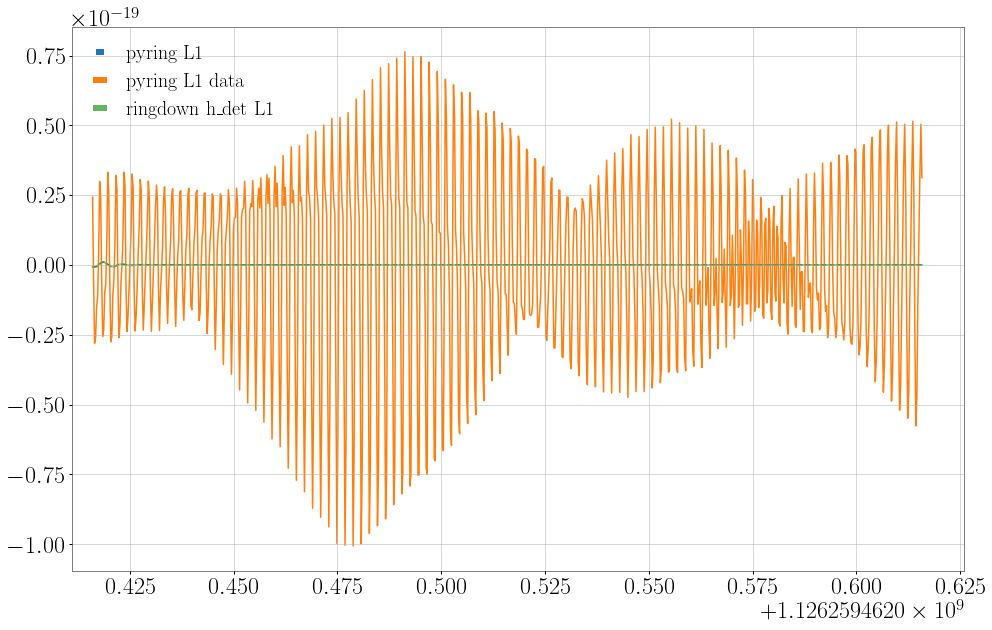

In [21]:
plt.figure(figsize=[16,10])

plt.plot(model.tevent+time_array['L1']+dt['L1'],pyring_wf['L1'],ls='--',label='pyring L1')

plt.plot(model.tevent+time_array['L1']+dt['L1'],pyring_data['L1'],label='pyring L1 data')

plt.plot(fit.analysis_data['L1'].index,par['h_det'][1],alpha=0.5,lw=2,label='ringdown h_det L1')

plt.xlim(fit.analysis_data['L1'].index[0]-0.005,fit.analysis_data['L1'].index[0]+0.21)
plt.legend(loc='best',fontsize=20)

In [22]:
fit.model_input['strain'][0]

1.126259e+09    1.433837e-20
1.126259e+09   -1.624430e-20
1.126259e+09    8.791991e-22
1.126259e+09   -3.314603e-21
1.126259e+09    1.548498e-20
                    ...     
1.126259e+09    1.514165e-20
1.126259e+09   -2.968092e-21
1.126259e+09   -1.122646e-20
1.126259e+09    3.029910e-21
1.126259e+09    8.516489e-21
Length: 819, dtype: float64

In [23]:
pyring_th1 = model.tevent+time_array['H1']+dt['H1']
tmin = max(pyring_th1[0],fit.model_input['strain'][0].index[0])
tmax = min(pyring_th1[-1],fit.model_input['strain'][0].index[-1])
tcommon = np.linspace(tmin,tmax,int(4096*(tmax-tmin)))

In [24]:
tcommon[0]

1126259462.4231222

In [25]:
from scipy.interpolate import interp1d

In [26]:
ringdown_interp = interp1d(fit.model_input['strain'][0].index,fit.model_input['strain'][0].values)

In [27]:
pyring_interp = interp1d(pyring_th1,pyring_data['H1'])

(-10.0, 10.0)

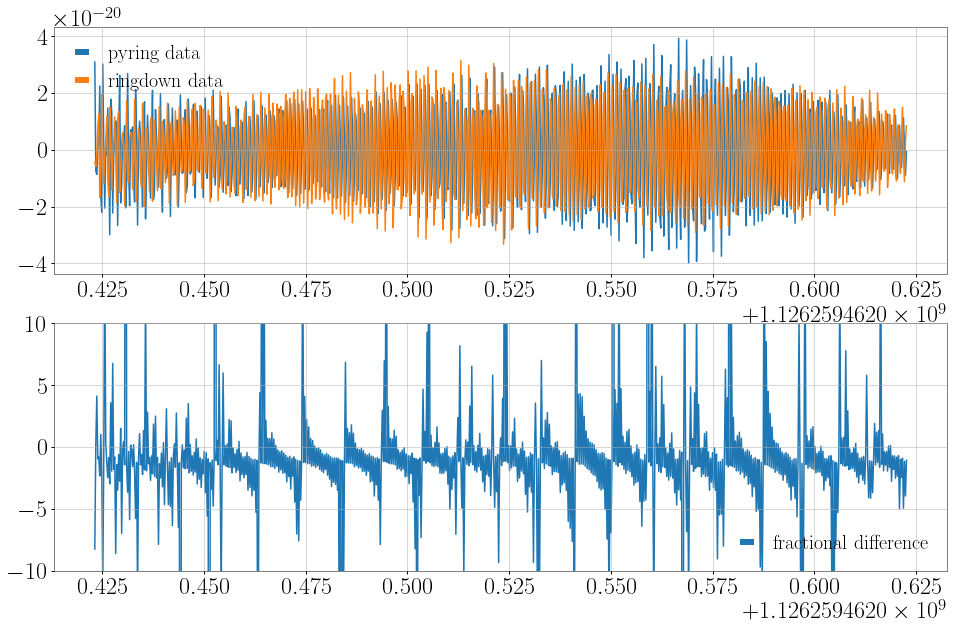

In [28]:
fig = plt.figure(figsize=[16,10])
ax = fig.add_subplot(211)
ax.plot(tcommon,pyring_interp(tcommon),label='pyring data')
ax.plot(tcommon,ringdown_interp(tcommon),label='ringdown data')
ax.legend(loc='best')

bx = fig.add_subplot(212)
bx.plot(tcommon,
        (pyring_interp(tcommon)-ringdown_interp(tcommon))/ringdown_interp(tcommon),
        label='fractional difference')
bx.legend(loc='best')
bx.set_ylim(-10,10)

# Check raw data

In [29]:
from gwpy.timeseries import TimeSeries

In [30]:
triggertime = input_par['trigtime']
T = float(input_par['datalen-download'])
s = int(triggertime)-(T/2.)
e = int(triggertime)+(T/2.)

In [31]:
pr_raw = {}
pr_raw['H1'] = TimeSeries.fetch_open_data('H1', 
                                          s, 
                                          e, 
                                          sample_rate = 16384, 
                                          verbose=2, 
                                          cache=True, 
                                          tag=u"GWOSC")

Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]


In [32]:
pr_raw['H1']

<TimeSeries([-1.13529608e-19, -1.34581618e-19, -1.23383687e-19,
             ..., -2.12401529e-19, -2.14546318e-19,
             -2.08975190e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625741e+09 s>,
            dt=<Quantity 6.10351562e-05 s>,
            name='Strain',
            channel=None)>

In [33]:
a = np.array(pr_raw['H1'])[16384:]

In [34]:
b = raw_strain['H1'].values[:-16384]

In [35]:
np.max(a-b)

0.0

# Raw data are the same! But conditioned data are not!

# How about SNR!

In [37]:
od = {'strain': fit.model_input['strain']}

In [38]:
od

{'strain': [1.126259e+09    1.433837e-20
  1.126259e+09   -1.624430e-20
  1.126259e+09    8.791991e-22
  1.126259e+09   -3.314603e-21
  1.126259e+09    1.548498e-20
                      ...     
  1.126259e+09    1.514165e-20
  1.126259e+09   -2.968092e-21
  1.126259e+09   -1.122646e-20
  1.126259e+09    3.029910e-21
  1.126259e+09    8.516489e-21
  Length: 819, dtype: float64,
  1.126259e+09   -5.933877e-21
  1.126259e+09   -2.811502e-20
  1.126259e+09   -2.611562e-20
  1.126259e+09   -1.492755e-20
  1.126259e+09   -1.154778e-20
                      ...     
  1.126259e+09    9.556086e-21
  1.126259e+09    3.246281e-20
  1.126259e+09    5.043024e-20
  1.126259e+09    3.123212e-20
  1.126259e+09   -1.984161e-20
  Length: 819, dtype: float64]}

In [39]:
cd = {k: v for k,v in fit.model_input.items() if k != 'strain'}

In [40]:
cd

{'nsamp': 819,
 'nmode': 2,
 'nobs': 2,
 't0': [1126259462.423, 1126259462.4160156],
 'times': [Float64Index([1126259462.4229736, 1126259462.4232178,  1126259462.423462,
                 1126259462.423706, 1126259462.4239502, 1126259462.4241943,
                1126259462.4244385, 1126259462.4246826, 1126259462.4249268,
                 1126259462.425171,
                ...
                1126259462.6204834, 1126259462.6207275, 1126259462.6209717,
                1126259462.6212158,   1126259462.62146,  1126259462.621704,
                1126259462.6219482, 1126259462.6221924, 1126259462.6224365,
                1126259462.6226807],
               dtype='float64', length=819),
  Float64Index([1126259462.4160156, 1126259462.4162598,  1126259462.416504,
                 1126259462.416748, 1126259462.4169922, 1126259462.4172363,
                1126259462.4174805, 1126259462.4177246, 1126259462.4179688,
                 1126259462.418213,
                ...
                1126259462.6

In [51]:
fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')

In [53]:
fit.result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [56]:
snr = fit.compute_posterior_snrs()